## 1. 패키지 다운로드 & 환경 세팅

In [1]:
!pip install transformers
!pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from transformers import SwinConfig, AutoImageProcessor, SwinForImageClassification, TrainingArguments, Trainer
from datasets import load_dataset, load_metric

import torch
import torchvision
import numpy as np

## 2. 데이터셋 준비

- pytorch 데이터셋 format 세팅

In [3]:
# dataset의 features의 'image', 'labels' 를 통일시켜주는 게 편하다
# 데이터셋마다 'img', 'image', 'images' 등 다양하게 표기되어 있음

dataset = load_dataset("cats_vs_dogs")
print('기존 :', dataset)

dataset['train'] = dataset['train'].rename_column("labels", "label")

# Pytorch 데이터셋 포맷 세팅
dataset.set_format("torch")

print('변경 후 :',dataset)

  0%|          | 0/1 [00:00<?, ?it/s]

기존 : DatasetDict({
    train: Dataset({
        features: ['image', 'labels'],
        num_rows: 23410
    })
})
변경 후 : DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 23410
    })
})


In [4]:
# 레이블 인덱스 별 레이블 지정

labels = dataset["train"].features["label"].names
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = i
    id2label[i] = label

print('인덱스 별 레이블 : ',id2label)

인덱스 별 레이블 :  {0: 'cat', 1: 'dog'}


## 3. Hugging Face 모델 세팅

*   feature_extractor : for image to patches
*   model : SwinTransformer for image classification



In [5]:
configuration = SwinConfig()
configuration.num_labels = 10

feature_extractor = AutoImageProcessor.from_pretrained("microsoft/swin-tiny-patch4-window7-224",
                                                        label2id=label2id,
                                                        id2label=id2label,
                                                        ignore_mismatched_sizes = True, 
                                                       )
model = SwinForImageClassification(configuration)

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


### # 데이터셋 transformation 및 preprocess 



In [6]:
from torchvision.transforms import (
    CenterCrop,
    Compose,
    Normalize,
    RandomHorizontalFlip,
    RandomResizedCrop,
    Resize,
    ToTensor,
)

normalize = Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std)
train_transforms = Compose(
        [
            RandomResizedCrop((feature_extractor.size['height'], feature_extractor.size['width'])),
            RandomHorizontalFlip(),
            ToTensor(),
            normalize,
        ]
    )

val_transforms = Compose(
        [
            Resize((feature_extractor.size['height'], feature_extractor.size['width'])),
            CenterCrop((feature_extractor.size['height'], feature_extractor.size['width'])),
            ToTensor(),
            normalize,
        ]
    )

def preprocess_train(example_batch):
    """Apply train_transforms across a batch."""
    example_batch["image"] = [
        train_transforms(image.convert("RGB")) for image in example_batch["image"]
    ]
    return example_batch

def preprocess_val(example_batch):
    """Apply val_transforms across a batch."""
    example_batch["image"] = [val_transforms(image.convert("RGB")) for image in example_batch["image"]]
    return example_batch

### # 데이터셋 split 및 transform 적용


In [7]:
splits = dataset["train"].train_test_split(test_size=0.1)
train_ds = splits['train']
val_ds = splits['test']

train_ds.set_transform(preprocess_train)
val_ds.set_transform(preprocess_val)

In [8]:
# 데이터셋 잘 적용되었는지 확인

example = train_ds[10]
print('label :',id2label[example['label']])
example['image']

label : cat


tensor([[[-1.6042, -1.5014, -1.4500,  ..., -0.6965, -0.6965, -0.6965],
         [-1.5185, -1.4500, -1.4329,  ..., -0.6965, -0.6965, -0.6965],
         [-1.4158, -1.3815, -1.3987,  ..., -0.6965, -0.6965, -0.6965],
         ...,
         [-1.5870, -1.5014, -1.4672,  ..., -0.0458, -0.0801, -0.1314],
         [-1.7240, -1.6727, -1.6213,  ..., -0.0801, -0.0629, -0.0629],
         [-1.8268, -1.7925, -1.7412,  ..., -0.0972, -0.0629, -0.0116]],

        [[-1.4230, -1.3880, -1.3704,  ..., -0.6527, -0.6527, -0.6527],
         [-1.3354, -1.3354, -1.3529,  ..., -0.6527, -0.6527, -0.6527],
         [-1.2304, -1.2654, -1.3179,  ..., -0.6527, -0.6527, -0.6527],
         ...,
         [-1.4930, -1.4230, -1.3880,  ..., -0.1800, -0.1975, -0.2325],
         [-1.6506, -1.5805, -1.5280,  ..., -0.2675, -0.2675, -0.2500],
         [-1.7556, -1.6856, -1.6155,  ..., -0.3375, -0.3025, -0.2500]],

        [[-0.8633, -0.9330, -1.0027,  ..., -0.5844, -0.5844, -0.5844],
         [-0.7761, -0.8807, -0.9853,  ..., -0

### # Pytorch DataLoader 생성

In [9]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_ds, shuffle=True, batch_size=8)
eval_dataloader = DataLoader(val_ds, batch_size=8)

In [12]:
from torch.optim import AdamW
from transformers import get_scheduler
import torch

optimizer = AdamW(model.parameters(), lr=5e-5)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

## 4. Pytorch 학습 코드로 모델 학습
- 입력 image를 트랜스포머 입력 patch들로 변환하는 preprocessor 에 먼저 넣어줘야 함
- model에는 입력 텐서와 레이블을 함께 넣어줘야 함



In [14]:
num_iter = 300
model.to(device)
model.train()
iteration = 0

while(True):
    total_loss = 0
    for batch in train_dataloader:
        batch["image"] = [x for x in batch["image"]]
        batch["image"] = feature_extractor(batch["image"], return_tensors="pt").pixel_values
        image = batch["image"].to(device)
        labels = batch["label"].to(device)
        
        outputs = model(image, labels = labels)
        loss = outputs.loss
        total_loss += loss

        loss.backward()

        optimizer.step()
        optimizer.zero_grad()

        iteration += 1
        if (iteration + 1) % 100 == 0:
          print(f'Iteration : {iteration+1}, Training Loss : {total_loss/100}')

        if (iteration + 1) == num_iter:
          break

    if (iteration + 1) == num_iter:
          print('end the training')
          break

model.save_pretrained('saved_model/')

Iteration : 100, Training Loss : 0.7069539427757263
Iteration : 200, Training Loss : 1.420106053352356
Iteration : 300, Training Loss : 2.1238269805908203
end the training


## 5. 모델 인퍼런스

- feature_extractor : pre-train된 포르세서 사용
- trained_model : 학습한 모델 정보가 있는 경로를 지정해서 학습한 모델 불러오기

In [15]:
feature_extractor = AutoImageProcessor.from_pretrained("microsoft/swin-tiny-patch4-window7-224")
trained_model = SwinForImageClassification(configuration).from_pretrained('/content/saved_model/')

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


predicted label : cat


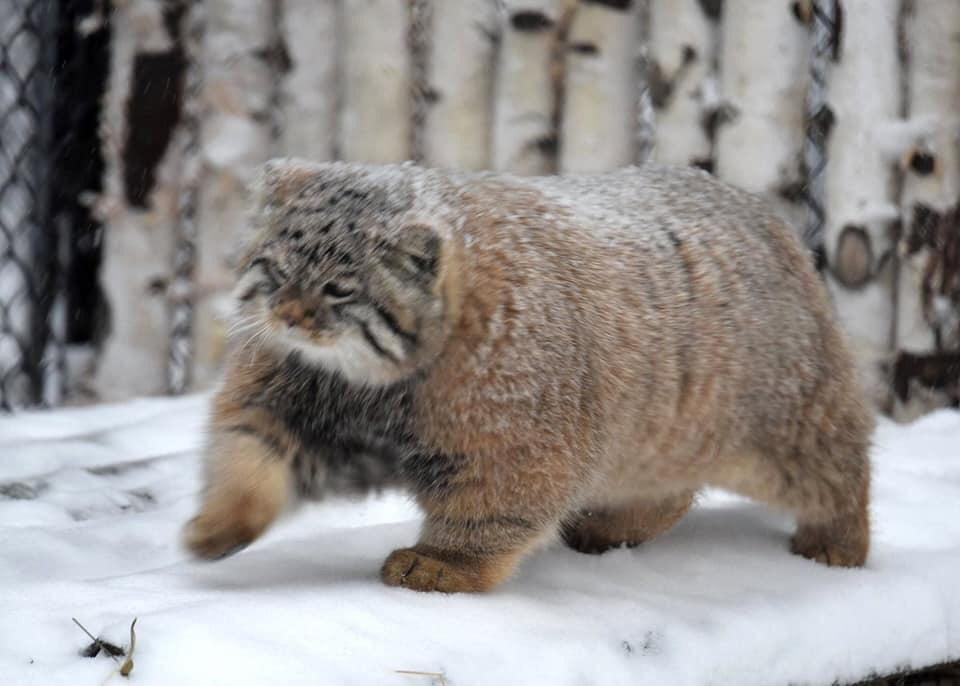

In [16]:
import requests
from io import BytesIO
from PIL import Image

url = "https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/pipeline-cat-chonk.jpeg"
res = requests.get(url)
image = Image.open(BytesIO(res.content))

inputs = feature_extractor(image, return_tensors="pt")

with torch.no_grad():
    outputs = trained_model(**inputs).logits

predicted_label = outputs.argmax(-1).item()
print('predicted label :',id2label[predicted_label])

image